<a id="ndvi_thresholds_top"></a>
# NDVI Thresholds
*****
# Notebook Summary

* LANDSAT 7 is used to detect changes in plant life both over time and between a baseline period and a target acquisition.
* Very basic xarray manipulations are performed.
* The data is cleaned of clouds and scanlines - both with and without creating mosaics (composite images).

<hr>

# Notebook Index

* [Import Dependencies and Connect to the Data Cube](#ndvi_thresholds_import)
* [Choose Platform and Product](#ndvi_thresholds_plat_prod)
* [Get the Extents of the Cube](#ndvi_thresholds_extents)
* [Define the Extents of the Analysis](#ndvi_thresholds_define_extents)
* [Examine cleaned, time-series data](#ndvi_thresholds_time_series)
  * [Retrieve the data from the datacube](#ndvi_thresholds_retrieve_data_time_series)
  * [Mask unclean data](#ndvi_thresholds_obtain_clean_mask_time_series)
  * [Filter out clouds and scan lines](#ndvi_thresholds_clean_mask_time_series)
  * [Calculate NDVI](#ndvi_thresholds_calculate)
  * [Chose an acquisition date for plotting a map of NDVI](#ndvi_thresholds_choose_acq_date)
  * [Examine true and false color maps](#ndvi_thresholds_true_false_maps)
  * [Plot NDVI with Thresholds](#ndvi_thresholds_plot_maps)
  * [Plot NDVI statistics over time](#ndvi_thresholds_time_series_analysis)
* [Examine cleaned, composited data](#ndvi_thresholds_composite)
  * [Retrieve the data from the datacube](#ndvi_thresholds_retrieve_data_composite)
  * [Mask unclean data](#ndvi_thresholds_obtain_clean_mask_composite)
  * [Filter out clouds and scan lines, and create a mosaic](#ndvi_thresholds_clean_mask_composite)
  * [Select a Target Date and Specify a Baseline For Comparison](#ndvi_thresholds_baseline)
  * [Calulate the NDVI for the Baseline and Target Scene](#ndvi_thresholds_compare)
  * [Plot the NDVI Anomalies](#ndvi_thresholds_plot)

<hr>

# How It Works

To detect changes in plant life, we use a measure called NDVI. 
* <font color=green>NDVI</font> is the ratio of the difference between amount of near infrared light <font color=red>(NIR)</font> and red light <font color=red>(RED)</font> divided by their sum.
<br>

$$ NDVI =  \frac{(NIR - RED)}{(NIR + RED)}$$  

<br>
<div class="alert-info">
The idea is to observe how much red light is being absorbed versus reflected. Photosynthetic plants absorb most of the visible spectrum's wavelengths when they are healthy.  When they aren't healthy, more of that light will get reflected.  This makes the difference between <font color=red>NIR</font> and <font color=red>RED</font> much smaller which will lower the <font color=green>NDVI</font>.  The resulting values from doing this over several pixels can be used to create visualizations for the changes in the amount of photosynthetic vegetation in large areas.
</div>

## <span id="ndvi_thresholds_import">Import Dependencies and Connect to the Data Cube [&#9652;](#ndvi_thresholds_top)</span>

In [1]:
import sys
import os
sys.path.append(os.environ.get('NOTEBOOK_ROOT'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

from dc_notebook_utilities import generate_metadata_report
from utils.data_cube_utilities.dc_display_map import display_map
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask, landsat_clean_mask_invalid
from utils.data_cube_utilities.vegetation import NDVI
from utils.data_cube_utilities.dc_rgb import rgb
from utils.data_cube_utilities.plotter_utils import \
    create_discrete_color_map, xarray_time_series_plot, figure_ratio
from utils.data_cube_utilities.dc_mosaic import create_mosaic, create_median_mosaic, \
                                                create_max_ndvi_mosaic, create_min_ndvi_mosaic

import datacube
from utils.data_cube_utilities.data_access_api import DataAccessApi
api = DataAccessApi()
dc = api.dc

## <span id="ndvi_thresholds_plat_prod">Choose Platform and Product [&#9652;](#ndvi_thresholds_top)</span>

In [2]:
# Get available products
products = dc.list_products()
# List LANDSAT 7 products
print(products[["platform", "name"]][products.platform == "LANDSAT_7"])

     platform                      name
id                                     
12  LANDSAT_7  ls7_collections_sr_scene
13  LANDSAT_7          ls7_ledaps_ghana
17  LANDSAT_7          ls7_ledaps_kenya
18  LANDSAT_7        ls7_ledaps_senegal
16  LANDSAT_7   ls7_ledaps_sierra_leone
19  LANDSAT_7       ls7_ledaps_tanzania
31  LANDSAT_7        ls7_ledaps_vietnam


In [3]:
# These are the platform (satellite) and product (datacube set) 
# used for this demonstration.
platform = "LANDSAT_8"
product = "ls8_lasrc_kenya"

The magnitudes of the different wavelengths of light can be quanitized and stored on a per pixel basis.  <font color=green>NDVI</font> only requires the use of <font color=red>NIR</font> and <font color=red>RED</font> light but there are many more wavelengths and some additional measures available.  One such additional measure is called <font color=darkblue>pixel_qa</font>.  This is a measure of the quality of the pixel for analysis. A breakdown of the values stored in <font color=darkblue>pixel_qa</font> are beyond the scope of this notebook but we encourage you to check our github for more information on the meaning behind the values stored within.
![](diagrams/rainy_demo/ls7_xarray.png) 

## <span id="ndvi_thresholds_extents">Get the Extents of the Cube [&#9652;](#ndvi_thresholds_top)</span>

In [4]:
# Get the extents of the cube.
descriptor = api.get_query_metadata(platform=platform, product=product, measurements=[])

# Store the latitudinal and longitudinal extents.
lat, lon = products.resolution[products.platform == platform].any()

In [5]:
#save extents
min_date, max_date = descriptor['time_extents']
min_lat, max_lat = descriptor['lat_extents']
min_lon, max_lon = descriptor['lon_extents']

#Adjust date string
min_date_str = str(min_date.year) + '-' + str(min_date.month) + '-' + str(min_date.day)
max_date_str = str(max_date.year) + '-' + str(max_date.month) + '-' + str(max_date.day)

#Round GPS coordinates to 3 decimal places
min_lat_rounded, max_lat_rounded = (np.round(min_lat, 3), np.round(max_lat, 3))
min_lon_rounded, max_lon_rounded = (np.round(min_lon, 3), np.round(max_lon, 3))

#display the total area available in this datacube product that can be used for analysis
display_map(latitude = (min_lat_rounded, max_lat_rounded),longitude = (min_lon_rounded, max_lon_rounded))

In [6]:
# Display metadata.
generate_metadata_report(min_date_str, max_date_str, 
                         min_lon_rounded, max_lon_rounded, lon,
                         min_lat_rounded, max_lat_rounded, lat)

,Min,Max,Resolution
Date:,2013-4-12,2020-1-19,
Longitude:,32.987,41.983,0.000269494585236
Latitude:,-4.997,5.997,-0.000269494585236


## <span id="ndvi_thresholds_define_extents">Define the Extents of the Analysis [&#9652;](#ndvi_thresholds_top)</span>

In [7]:
# Specify latitude and longitude bounds within the full extents 
# shown in the metadata report above (reduce area for faster processing times).
# Kenya
lon_small = (35.61, 35.6325) # Kenya - Lake Kamnarok (large)
lat_small = (0.6, 0.6375) # Kenya - Lake Kamnarok (large)

# Display the subset for analysis.
display_map(latitude = lat_small, longitude = lon_small)

# <span id="ndvi_thresholds_time_series">Examine cleaned, time-series data [&#9652;](#ndvi_thresholds_top)</span>

## <span id="ndvi_thresholds_retrieve_data_time_series">Retrieve the data from the datacube [&#9652;](#ndvi_thresholds_top)</span>

In [8]:
# Select a date range to retrieve data for.
time_extents = ("2017-1-1", "2017-12-31")

landsat_dataset = dc.load(lat = lat_small,
                          lon = lon_small,
                          platform = platform,
                          time = time_extents,
                          product = product,
                          measurements = ['red', 'green', 'blue', 'swir1', 'swir2', 'nir', 'pixel_qa'],
                          group_by='solar_day')

## <span id="ndvi_thresholds_obtain_clean_mask_time_series">Mask unclean data [&#9652;](#ndvi_thresholds_top)</span>

In [9]:
# Get the clean mask for the LANDSAT satellite platform
clean_mask = (landsat_qa_clean_mask(landsat_dataset, platform=platform) & \
             (landsat_dataset != -9999).to_array().any('variable') & \
             landsat_clean_mask_invalid(landsat_dataset))

In [10]:
cleaned_landsat_dataset = landsat_dataset.where(clean_mask)

## <span id="ndvi_thresholds_clean_mask_time_series">Filter out clouds and scan lines [&#9652;](#ndvi_thresholds_top)</span>

In [11]:
time_ind_to_show = 12

**Before masking clouds and scan lines**

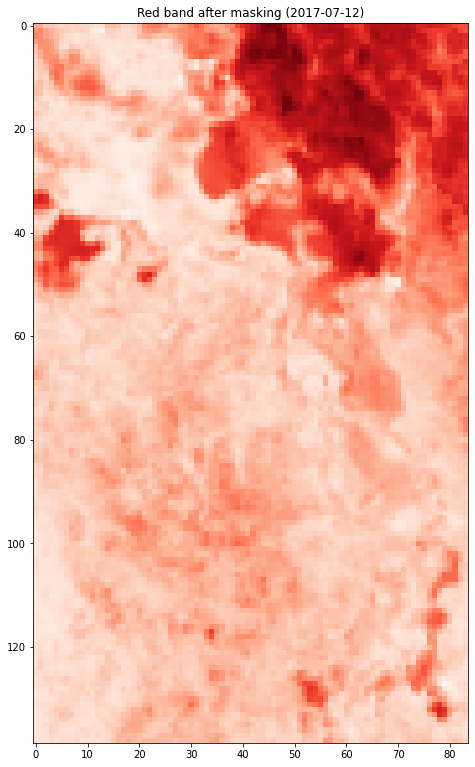

In [12]:
std_figsize = figure_ratio(landsat_dataset, fixed_width=8)
fig = plt.figure(figsize=std_figsize)
plt.imshow(landsat_dataset.isel(time=time_ind_to_show).red, cmap='Reds')
plt.title(f"Red band after masking "\
          f"({np.datetime_as_string(landsat_dataset.time.values[time_ind_to_show], unit='D')})")
plt.show()

**After masking clouds and scan lines**

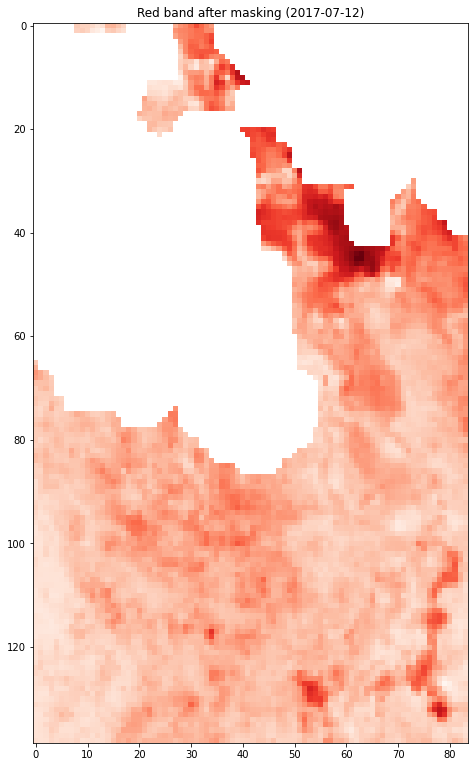

In [13]:
fig = plt.figure(figsize=std_figsize)
plt.imshow(cleaned_landsat_dataset.isel(time=time_ind_to_show).red, cmap='Reds')
plt.title(f"Red band after masking "\
          f"({np.datetime_as_string(landsat_dataset.time.values[time_ind_to_show], unit='D')})")
plt.show()

## <span id='ndvi_thresholds_calculate'>Calculate NDVI [&#9652;](#ndvi_thresholds_top)</span>

In [14]:
ndvi_data_arr = NDVI(cleaned_landsat_dataset)
ndvi = ndvi_data_arr.to_dataset(name='ndvi')

## <span id='ndvi_thresholds_choose_acq_date'>Chose an acquisition date for plotting a map of NDVI [&#9652;](#ndvi_thresholds_top)</span>

In [15]:
acquisition_dates = np.array([np.datetime_as_string(time, unit='D') 
                              for time in cleaned_landsat_dataset.time])
print("Acquisition Dates:")
print(acquisition_dates)

Acquisition Dates:
['2017-01-01' '2017-01-17' '2017-02-02' '2017-02-18' '2017-03-06'
 '2017-03-22' '2017-04-07' '2017-04-23' '2017-05-09' '2017-05-25'
 '2017-06-10' '2017-06-26' '2017-07-12' '2017-07-28' '2017-08-13'
 '2017-08-29' '2017-09-14' '2017-09-30' '2017-10-16' '2017-11-01'
 '2017-11-17' '2017-12-03' '2017-12-19']


In [16]:
acquisition_date = '2017-04-23'
acquisition_index = np.argmax(acquisition_dates == acquisition_date)
if acquisition_index == 0 and acquisition_date != acquisition_dates[0]:
    raise ValueError("Acquisition date '{}' is not in the list of acquisition dates above.".format(acquisition_date))

## <span id='ndvi_thresholds_true_false_maps'>Examine true and false color maps [&#9652;](#ndvi_thresholds_top)</span>

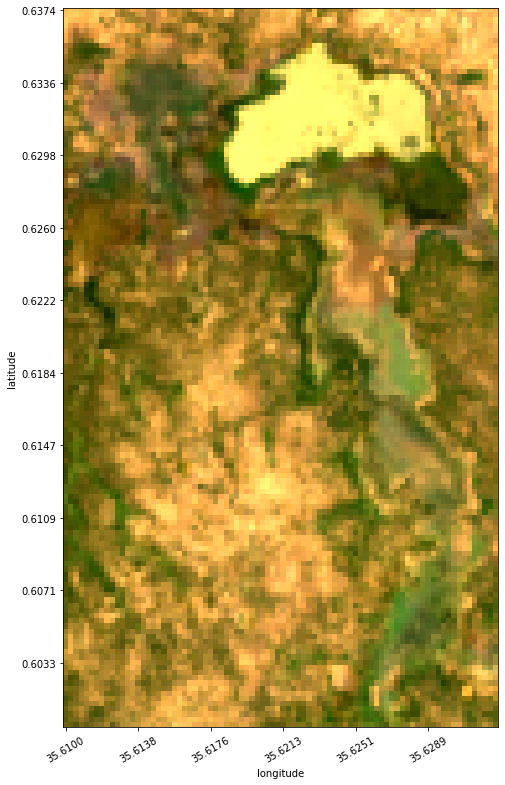

In [17]:
# True color plot
fig = plt.figure(figsize=std_figsize)
rgb(cleaned_landsat_dataset, time_index=acquisition_index, 
    bands=['red', 'green', 'blue'], fig=fig)
plt.show()

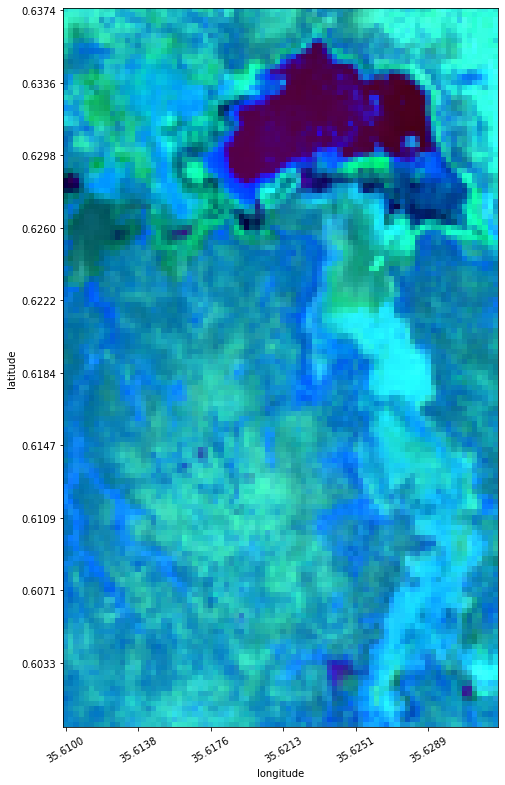

In [18]:
# False color plot
fig = plt.figure(figsize=std_figsize)
rgb(cleaned_landsat_dataset, time_index=acquisition_index, 
    bands=['green', 'swir1', 'nir'], fig=fig)
plt.show()

## <span id="ndvi_thresholds_plot_maps">Plot NDVI with Thresholds [&#9652;](#ndvi_thresholds_top)</span>

In [19]:
ndvi_plotting_data = ndvi.isel(time=acquisition_index)

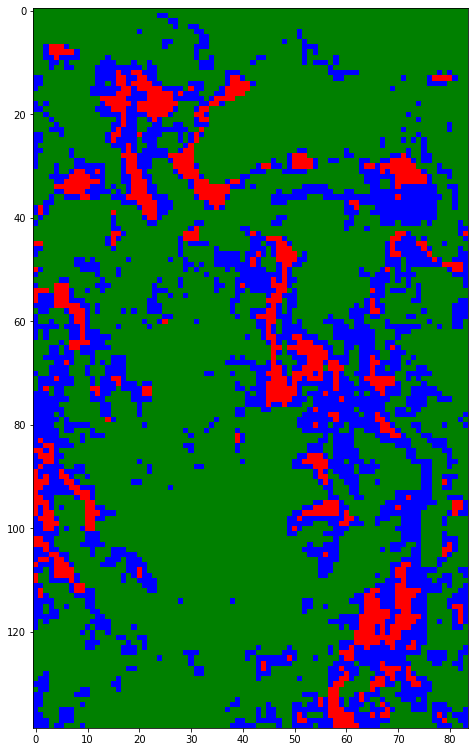

In [20]:
th = [-0.2, 0.2] # Color thresholds
cmap = create_discrete_color_map(th=th, colors=['green', 'blue', 'red'], data_range=[-1,1])
plt.figure(figsize=std_figsize)
plt.imshow(ndvi_plotting_data.ndvi.values, cmap=cmap)
plt.show()

## <span id="ndvi_thresholds_time_series_analysis">Plot NDVI statistics over time [&#9652;](#ndvi_thresholds_top)</span>

In [21]:
ndvi_dataset = ndvi_data_arr.to_dataset(name='NDVI')

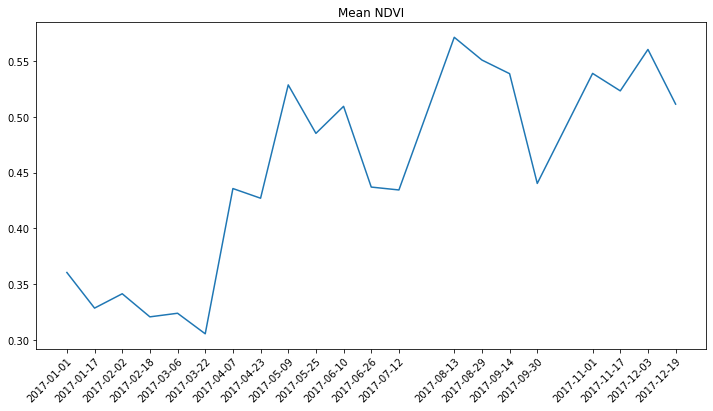

In [22]:
xarray_time_series_plot(ndvi_dataset, {'NDVI':{'mean':[{'line':{}}]}},
                        show_legend=False)
plt.title("Mean NDVI")
plt.show()

# <span id="ndvi_thresholds_composite">Examine cleaned, composited data [&#9652;](#ndvi_thresholds_top)</span>

## <span id="ndvi_thresholds_retrieve_data_composite">Retrieve the data from the datacube [&#9652;](#ndvi_thresholds_top)</span>

In [23]:
landsat_dataset = dc.load(lat = lat_small,
                          lon = lon_small,
                          platform = platform,
                          time = time_extents,
                          product = product,
                          measurements = ['red', 'nir', 'pixel_qa'],
                          group_by='solar_day')

## <span id="ndvi_thresholds_obtain_clean_mask_composite">Mask unclean data [&#9652;](#ndvi_thresholds_top)</span>

In [24]:
# Get the clean mask for the LANDSAT satellite platform.
clean_mask = (landsat_qa_clean_mask(landsat_dataset, platform=platform) & \
             (landsat_dataset != -9999).to_array().any('variable') & \
             landsat_clean_mask_invalid(landsat_dataset))

In [25]:
landsat_dataset = landsat_dataset.where(clean_mask)

## <span id="ndvi_thresholds_clean_mask_composite">Filter out clouds and scan lines, and create a mosaic [&#9652;](#ndvi_thresholds_top)</span>

In [26]:
landsat_composite = landsat_dataset.median('time')

## <span id="ndvi_thresholds_baseline">Select a Target Date and Specify a Baseline For Comparison [&#9652;](#ndvi_thresholds_top)</span>

In [27]:
# Get a list of available image aquisition dates.
acquisitions_list = landsat_dataset.time.values
print("There are {} acquisitions to choose from:".format(len(acquisitions_list)))
for index, acquisition in enumerate(acquisitions_list):
    print("Index: {}, Acquisition: {}".format(index, pd.to_datetime(str(acquisition)).strftime('%Y-%m-%d')))

There are 23 acquisitions to choose from:
Index: 0, Acquisition: 2017-01-01
Index: 1, Acquisition: 2017-01-17
Index: 2, Acquisition: 2017-02-02
Index: 3, Acquisition: 2017-02-18
Index: 4, Acquisition: 2017-03-06
Index: 5, Acquisition: 2017-03-22
Index: 6, Acquisition: 2017-04-07
Index: 7, Acquisition: 2017-04-23
Index: 8, Acquisition: 2017-05-09
Index: 9, Acquisition: 2017-05-25
Index: 10, Acquisition: 2017-06-10
Index: 11, Acquisition: 2017-06-26
Index: 12, Acquisition: 2017-07-12
Index: 13, Acquisition: 2017-07-28
Index: 14, Acquisition: 2017-08-13
Index: 15, Acquisition: 2017-08-29
Index: 16, Acquisition: 2017-09-14
Index: 17, Acquisition: 2017-09-30
Index: 18, Acquisition: 2017-10-16
Index: 19, Acquisition: 2017-11-01
Index: 20, Acquisition: 2017-11-17
Index: 21, Acquisition: 2017-12-03
Index: 22, Acquisition: 2017-12-19


In [28]:
# Select a scene to check for anomalies (one of the acquisition dates shown above).
acquisition_index = 6 # Check for anomalies on 2018-02-21. (Kenya - Lake Kamnarok)

scene_sel_datetime = acquisitions_list[acquisition_index]
print("Date selected to check for anomalies: ", scene_sel_datetime)

# Select scenes to form a baseline (must be a list of two elements - the start and end indices).
baseline_date_indices = list(range(0,len(acquisitions_list))) # Use the full time range as the baseline (Kenya - Lake Kamnarok)

baseline_datetimes = np.array([pd.to_datetime(str(date)) for date in acquisitions_list[baseline_date_indices]])
print("First and last dates selected for baseline: ", [np64.strftime('%Y-%m-%d') for np64 in baseline_datetimes[[0,-1]]])

# Create a dictionary of the different mosaic method options.
mosaic_methods = {'Most Recent':create_mosaic, 'Least Recent':create_mosaic,'Median':create_median_mosaic,
                  'Max NDVI':create_max_ndvi_mosaic, 'Min NDVI':create_min_ndvi_mosaic}

# Select a mosaic method for the baseline.
# (One of ['Most Recent','Least Recent','Median','Max NDVI','Min NDVI']).
mosaic_method_label = 'Max NDVI'

mosaic_method = mosaic_methods[mosaic_method_label]
print("Selected mosaic method: ", mosaic_method_label)

# Select a percentage threshold for anomalies.
threshold_percent = 0.60
print("Threshold percentage selected for anomalies: {}%".format(threshold_percent*100))

Date selected to check for anomalies:  2017-04-07T07:48:29.000000000
First and last dates selected for baseline:  ['2017-01-01', '2017-12-19']
Selected mosaic method:  Max NDVI
Threshold percentage selected for anomalies: 60.0%


In [29]:
baseline_mosaic = mosaic_method(landsat_dataset.sel(time=baseline_datetimes), 
                                clean_mask=clean_mask.sel(time=baseline_datetimes))

## <span id="ndvi_thresholds_compare">Calulate the NDVI for the Baseline and Target Scene [&#9652;](#ndvi_thresholds_top)</span>

In [30]:
# Calculate the NDVI baseline values
ndvi_baseline = NDVI(baseline_mosaic)

# Calculate the NDVI values in the target scene
ndvi_scene = NDVI(landsat_dataset.sel(time=scene_sel_datetime))

# Determine the percentage change
percentage_change = abs((ndvi_baseline - ndvi_scene) / (ndvi_baseline+sys.float_info.epsilon))

## <span id="ndvi_thresholds_plot">Plot the NDVI Anomalies [&#9652;](#ndvi_thresholds_top)</span>

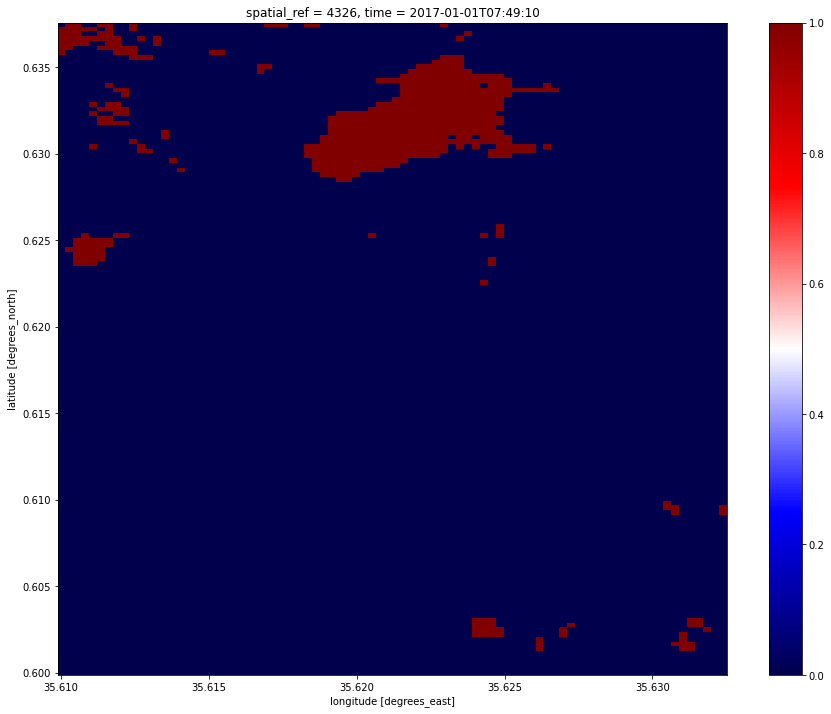

In [31]:
import matplotlib.pyplot as plt

# Use a cutoff value
anom = percentage_change > threshold_percent

# Set plot size
plt.figure(figsize = (15,12))
anom.plot(cmap='seismic')
plt.show()

If you used the original values for everything up to this point, you can clearly see an NDVI anomaly. This indicates that there was a measurable difference in the amount of photosynthetic plants in the lake basin compared to the standard defined by the baseline composite image.

In [32]:
display_map(latitude = lat_small,longitude = lon_small)